In [1]:
include("ArduinoFunctions.jl"); include("DFfunctions.jl"); include("SimpleSoapyLMS7.jl")
using Plots, Statistics, StatsBase

# Setup some parameters

In [2]:
sampRate = 2048e3; #Sample rate
desiredStationMHz = 108.0e6
desiredStationMHz2 = 107e6 #desiredStationMHz - 0.75
fTx = 108e6
f0 = desiredStationMHz-0.5e6; #center frequency
buffsz = 1024; #buffer size for each FFT
timeS = 15; #Total length of sampling

zeroPaddingMultiplier = 2;
zeroPadding = zeroPaddingMultiplier - 1;
buffszPadded = zeroPaddingMultiplier*buffsz;

timeSamp = Int(floor(timeS * sampRate / buffsz)); #Number of buffers to fill in timeS
storeIq = zeros(ComplexF32, buffsz*timeSamp); 
storeIq2 = zeros(ComplexF32, buffsz*timeSamp);

In [3]:
# create a re-usable buffer for rx samples
buff = Array{ComplexF32}(undef, buffsz)
buff2 = Array{ComplexF32}(undef, buffsz)


#create reu-usable buffer for tx
buffTx =  Array{ComplexF32}(undef, buffsz)
buffTx = createTone(sampRate,fTx,buffsz)
buffTx = [convert(typeof(buff),buffTx)];

# Parameters for storing IQ data in Arrays
numBuffs = Int(floor(timeS * sampRate / buffsz)) #Number of buffers to fill in timeS
storeIq = zeros(ComplexF32, buffsz*numBuffs) 
storeIq2 = zeros(ComplexF32, buffsz*numBuffs)

# Parameters for streaming
flags = Ref{Cint}()
timeNs = Ref{Clonglong}()
buffs = [buff,buff2] 

# Array to store IQ data
storeBuff = zeros(ComplexF32,numBuffs, buffsz);
storeBuff2 = zeros(ComplexF32,numBuffs, buffsz);

# Connect to and setup LimeSDR

In [4]:
Lime = connectAndSetupLime(sampRate,true,true,true,f0,f0,fTx)

Sample rate 1: 2.048 MHz
Center frequency 1: 107.5 MHz
Rx Gain 1 set


[INFO] Make connection: 'LimeSDR-USB [USB 3.0] 907060246091F'
[INFO] Reference clock 30.72 MHz
[INFO] Device name: LimeSDR-USB
[INFO] Reference: 30.72 MHz
[INFO] LMS7002M register cache: Disabled
[INFO] RX LPF configured


Sample rate 2: 2.048 MHz
Center frequency 1: 107.5 MHz
Rx Gain 2 set


[INFO] RX LPF configured


Sample rate TX: 2.048 MHz
Center frequency Tx: 108.0 MHz
Tx Gain set to50


[INFO] Filter calibrated. Filter order-4th, filter bandwidth set to 5 MHz.Real pole 1st order filter set to 2.5 MHz. Preemphasis filter not active
[INFO] TX LPF configured


Ptr{SoapySDR.SoapySDRDevice} @0x00000000047d5850

# Setup Stream

In [5]:
rxStream, txStream = setupStream(Lime)

[INFO] Tx calibration finished
[INFO] Rx calibration finished
[INFO] Rx calibration finished


(Ptr{SoapySDR.SoapySDRStream} @0x0000000005bd51d0, Ptr{SoapySDR.SoapySDRStream} @0x00007f6454003d00)

# Sample and transmit calibration tone 

In [6]:
sampleAndTxForTime(Lime, timeS, rxStream, txStream, buffs, buffTx, buffsz, storeBuff, storeBuff2)

# Disconnect LimeSDR

In [7]:
disconnectLime(Lime,rxStream,txStream)

0

# Reformat Data

In [8]:
#Save complex and absolute info seperately (for convenience)

storeFftComplex = im*zeros(timeSamp, buffszPadded)
storeFft = zeros(timeSamp, buffszPadded)

storeFftComplex2 = im*zeros(timeSamp, buffszPadded)
storeFft2 = zeros(timeSamp, buffszPadded)

for i = 1:size(storeBuff)[1]
    
    tempbuff = [storeBuff[i,:];zeros(buffsz*zeroPadding)]
    tempfft = fftshift(fft(tempbuff))
    local storeFftComplex[i,:] = tempfft;
    
    tempbuff = [storeBuff2[i,:];zeros(buffsz*zeroPadding)]
    tempfft = fftshift(fft(tempbuff))
    local storeFftComplex2[i,:] = tempfft;
end


storeFft =  20 .*log10.(abs.(storeFftComplex));
storeFft2 =  20 .*log10.(abs.(storeFftComplex2));


# get IQ arrays
#storeIq = Array(reshape(storeBuff', :, size(storeBuff)[1]*size(storeBuff)[2])')[:];
#storeIq2 = Array(reshape(storeBuff2', :, size(storeBuff2)[1]*size(storeBuff2)[2])')[:];


In [9]:
storeBuff = 0;
storeBuff2 = 0;
GC.gc()

# Get product of the two Rx FFTs

In [10]:
FFTProduct = MatFftProduct(storeFftComplex, storeFftComplex2);

# Setup paramters for plotting

In [11]:
ticks, FreqIndexMHz = makeFreqIndex(buffszPadded-1)

(0:1:2047, [106.48, 106.48, 106.48, 106.48, 106.48, 106.48, 106.48, 106.48, 106.48, 106.49  …  108.51, 108.52, 108.52, 108.52, 108.52, 108.52, 108.52, 108.52, 108.52, 108.52])

In [12]:
@show peakIndex = getFMStationPeakIndex(FFTProduct,buffsz,FreqIndexMHz,desiredStationMHz/1e6);
@show peakIndex2 = getFMStationPeakIndex(FFTProduct,buffsz,FreqIndexMHz,desiredStationMHz2/1e6);

peakIndex = getFMStationPeakIndex(FFTProduct, buffsz, FreqIndexMHz, desiredStationMHz / 1.0e6) = 1525
peakIndex2 = getFMStationPeakIndex(FFTProduct, buffsz, FreqIndexMHz, desiredStationMHz2 / 1.0e6) = 125


# Get the phase angle difference over time between the two channels at a particular frequency

In [13]:
AngleDif = MatAngleDif(FFTProduct, peakIndex);
AngleDif2 = MatAngleDif(FFTProduct, peakIndex2);

# Plot Magnitude of FFT1 and FFT2

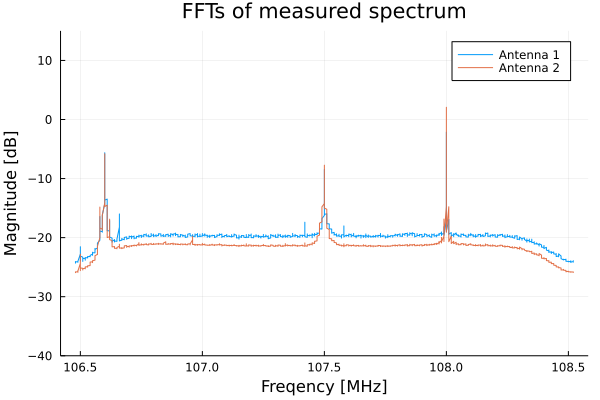

In [20]:
p1 = plot(FreqIndexMHz,mean.(eachcol(storeFft)),ylims=(-40,15), label = "Antenna 1", title = "FFTs of measured spectrum")
plot!(FreqIndexMHz,mean.(eachcol(storeFft2)),ylims=(-40,15),ylabel = "Magnitude [dB]", xlabel = "Freqency [MHz]",label = "Antenna 2")

display(p1)

# Plot phase difference at target frequency vs Time

Average phase diff target Freq 1: -76.829066848391
Average phase diff target Freq 2: -72.10205482987891


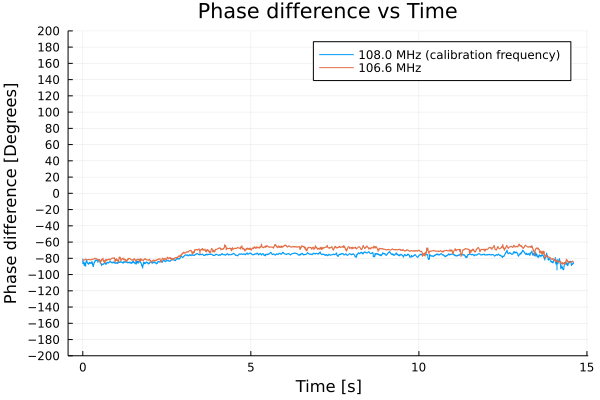

In [15]:
FFTAverage = (moving_average(FFTProduct[:,peakIndex],100));
FFTAverage2 = (moving_average(FFTProduct[:,peakIndex2],100));

time = (size(FFTAverage)[1])/buffszPadded
step = time/size(FFTAverage)[1]
timeIndex = 0:step:time-step
m1 = angle(mean(FFTProduct[:,peakIndex]))*180/pi;
m2 = angle(mean(FFTProduct[:,peakIndex2]))*180/pi
println("Average phase diff target Freq 1: ", m1)
println("Average phase diff target Freq 2: ", m2)
label = string(FreqIndexMHz[peakIndex])*" MHz (calibration frequency)"
plot(timeIndex,angle.(FFTAverage)*180/pi,ylims=(-200,200),yticks=-200:20:200,label = label, title = "Phase difference vs Time")
label = string(FreqIndexMHz[peakIndex2])*" MHz"
plot!(timeIndex,angle.(FFTAverage2)*180/pi,ylims=(-200,200),yticks=-200:20:200,ylabel = "Phase difference [Degrees]", xlabel = "Time [s]", label = label)

# Plot histograms of phase difference measurements at target Frequencies

Mode bin: -77.34930234266115
Standard dev: 15.26478132705299


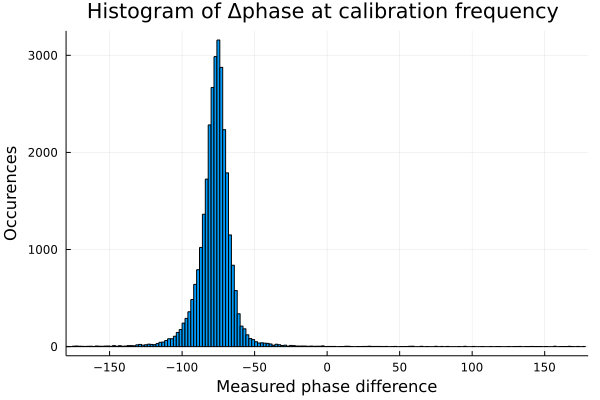

In [16]:
hist = StatsBase.fit(Histogram,AngleDif,nbins=180)
a1 = hist.edges[1][argmax(hist.weights)]*180/pi;
s1 = std(AngleDif)*180/pi
println("Mode bin: ",a1)
println("Standard dev: ", s1)
histogram(AngleDif.*180/pi,bins=180,xlims=(-180,180), ylabel = "Occurences", xlabel = "Measured phase difference",title = "Histogram of Δphase at calibration frequency ",legend = false)



Mode bin: -71.6197243913529
Standard dev: 38.41773734930671


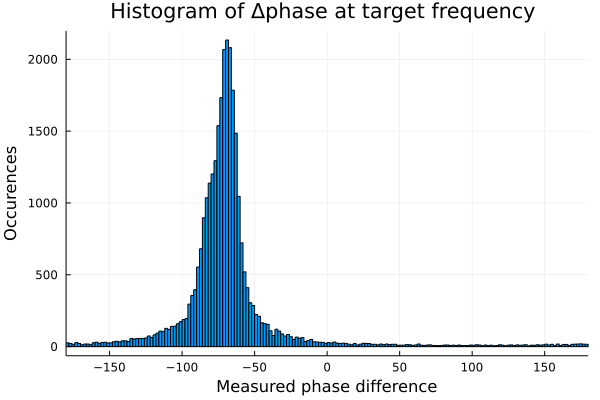

In [17]:
hist = StatsBase.fit(Histogram,AngleDif2,nbins=180)
a2 = hist.edges[1][argmax(hist.weights)]*180/pi;
s2 = std(AngleDif2)*180/pi;
println("Mode bin: ",a2)
println("Standard dev: ", s2)
histogram(AngleDif2.*180/pi,bins=180,xlims=(-180,180), ylabel = "Occurences", xlabel = "Measured phase difference", title = "Histogram of Δphase at target frequency ",legend = false)

In [18]:
using DataFrames
using CSV

df = DataFrame(a = [m1], b= [m2] , c = [a1], d = [a2], e = [s1] , f =[s2])


CSV.write("test_in_line.csv", df, header = false, append = true)


"test_in_line.csv"